# ecFlow eLearning episode-2

## Reminder
* How to start the server?
* What is a definition file?
* What are tasks templates scripts and headers, and their location?
* [ecFlow documentation](https://software.ecmwf.int/wiki/display/ECFLOW/Documentation)
* [slides from the course](https://software.ecmwf.int/wiki/download/attachments/13207146/ecflowcourse2018.pdf)
* Here we focus on migrating scripts to ecflow p50
  * [shell task example](#Turning-a-cron-into-a-task): retrieve observation regularly. `curl` `cron`
  * [another example](#Add-a-cron-task-for-ecFlow-server-daily-log-renewal): daily log renewal `bash`
  * [python task example](#Turning-a-python-script-into-a-task): the Lorenz system `python` `numpy` `matplotlib`

  * designing a suite p52-57:
    * Clustering [kmeans](kmeans.ipynb)  
    * [The ENIAC project](#ENIAC) which uses `octave`
    * Atmospheric-Oceanographic-DA models
        * Link to [DA](DA.ipynb) `git` `enkf` ![NERSC](https://www.nersc.no/sites/www.nersc.no/files/cti_flex_logo.png)
        * Link to [LMDZ](LMDZ.ipynb) `snv` `gfortran` ![LMDZ](http://lmdz.lmd.jussieu.fr/logo.png)
        * Link to [NEMO](NEMO.ipynb) `netcdf` ![nemo](https://www.nemo-ocean.eu/wp-content/uploads/NEMO_logo_Black_159x50.png)
        * Link to [WRF](WRF.ipynb) ![wrf](http://www2.mmm.ucar.edu/wrf/users/images/wrf_logo.jpg)
        * Link to [OpenIFS?](OpenIFS.ipynb)

From the initial e-learning:
* [ecFlow eLearning](https://www.ecmwf.int/assets/elearning/ecflow/ecflow1/story_html5.html)
* [Docker](https://www.docker.com/) may be used to practice ecFlow with a local ecFlow image `docker` ![docker](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Docker_%28container_engine%29_logo.svg/220px-Docker_%28container_engine%29_logo.svg.png)
* A [dockerfile](https://hub.docker.com/r/eowyn/debian-ecflowui/~/dockerfile/) may help to install ecFlow.

This tutorial illustrates the following slides from the course.

In [1]:
%%bash
# sudo apt get install graphviz octave
for run in curl octave ecflow_server dot; do
  which $run 2>/dev/null || echo "#WAR: $run is a requirement below"
done
# pip3 install matplotlib scipy mpl_toolkits
for lib in numpy matplotlib scipy graphviz; do
  python3 -c "import $lib" || echo "#WAR: python library $lib needed" && echo $lib OK
done

/usr/bin/curl
#WAR: octave is a requirement below
/usr/local/bin/ecflow_server
/usr/bin/dot
numpy OK
matplotlib OK
scipy OK
graphviz OK


In [11]:
%%bash
module load python3 2>/dev/null
which module && module unload ecflow && module load ecflow/4.12.0 2>/dev/null 
which ecflow_client || echo "Please provide the ecflow PATH"
export ECF_PORT=$((1500 + $(id -u)))
ecflow_start.sh -p $ECF_PORT > /dev/null
# ecflow_ui&  # would not run in background with Jupyter
cd $HOME/ecflow_server && mkdir -p files include img

/home/map/bin/module
/usr/local/bin/ecflow_client


In [12]:
import os; os.system("ecflow_ui &")

0

In [13]:
#URL=http://www.met.reading.ac.uk/weatherdata/images/0.25WIND.png && curl $URL > img/rdg_wind.png
! URL=http://www.met.reading.ac.uk/weatherdata/images/2SCNT.png && curl $URL > img/rdg_temp.png
! URL=https://www.meteoalarm.eu/maps/EU-$(date +%y%m%d).gif && echo $URL && curl "$URL" > img/meteoalarm.gif
# Minute Hour      Day of Month Month         Day of Week        Command    
# (0-59) (0-23)    (1-31)      (1-12 Jan-Dec) (0-6 Sun-Sat)                
#    1   0,6,12,18 *           *              *                  date

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  213k  100  213k    0     0   610k      0 --:--:-- --:--:-- --:--:--  610k
https://www.meteoalarm.eu/maps/EU-191010.gif
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16873    0 16873    0     0  42824      0 --:--:-- --:--:-- --:--:-- 43043


* Thanks [Reading University](img/rdg_temp.png)
* Thanks [Meteo-Alarm](img/meteoalarm.gif)

### Let's create header files: head.h tail.h

In [14]:
%%bash
file=$HOME/ecflow_server/include/head.h
if [[ ! -f $file ]]; then cat > $file <<@@
#!%SHELL:/bin/bash%
#set -e # stop the shell on first error
#set -u # fail when using an undefined variable
#set -x # echo script lines as they are executed
# Defines the variables that are needed for any communication with ECF
export ECF_PORT=%ECF_PORT%    # The server port number
export ECF_HOST=%ECF_HOST%    # where the server is running
export ECF_NAME=%ECF_NAME%    # The name of this current task
export ECF_PASS=%ECF_PASS%    # A unique password
export ECF_TRYNO=%ECF_TRYNO%  # Current try number of the task
export ECF_RID=$$             # record the process id. Also used for
                              # zombie detection
# Define the path where to find ecflow_client
# make sure client and server use the *same* version.
# Important when there are multiple versions of ecFlow
export PATH=/usr/local/apps/ecflow/%ECF_VERSION%/bin:$PATH
export PATH=$PATH:/usr/local/apps/ecflow/bin:/usr/local/bin
# Define a error handler
ERROR() {
   set +e                      # Clear -e flag, so we don't fail
   wait                        # wait for background process to stop
   ecflow_client --abort=trap  # Notify ecFlow that something went
                               # wrong, using 'trap' as the reason
   trap 0                      # Remove the trap
   exit 0                      # End the script
}
trap ERROR 0
# Tell ecFlow we have started
ecflow_client --init=$$ ; set -eux
@@
fi

In [15]:
%%bash
file=$HOME/ecflow_server/include/tail.h
if [[ ! -f $file ]]; then
cat > $file <<@@
set +x
wait           # wait for background process to stop
ecflow_client --complete  # Notify ecFlow of a normal end
trap 0                    # Remove all traps
exit 0                    # End the shell
@@
fi

### Let's create the suite, the script

In [16]:
import os, pwd, sys; v="2.7"; v = "3.6"
lib = "/usr/local/apps/ecflow/current/lib/python%s/site-packages/ecflow" % v
lib = "/usr/local/lib/python%s/site-packages/ecflow" % v ; sys.path.append(lib)
import ecf; from ecf import (Client, Defs, Suite, Family, Task, Edit, Trigger, Defstatus, Cron, Label)
home = os.getenv("HOME") + "/ecflow_server" ; user = os.getenv("USER")
node = Suite("obs").add(  # SUITE DEFINITION
    Defstatus("suspended"),
    Edit(ECF_HOME=home, ECF_INCLUDE=home + "/include", ECF_FILES=home + "/files",
         ECF_EXTN=".ecg",  # current convention for generated task extension
         ECF_JOB_CMD="%ECF_JOB% > %ECF_JOBOUT% 2>&1", ),
    Family("acq").add(
        Task("cmd").add(
            Cron("00:01 18:01 06:00"),  # run four times a day
            Edit(CMD="curl",
     ARGS="http://www.met.reading.ac.uk/weatherdata/images/0.25WIND.png" +
                 "> rdg_wind.png")), ))
# CREATE SCRIPT TEMPLATE
with open(home + "/files/cmd.ecg", 'w') as task_template:
    print("""#!%SHELL:/bin/bash%
%include <head.h>
 %CMD:echo% %ARGS:OK%
%include <tail.h>""", file=task_template)
def get_username(): return pwd.getpwuid(os.getuid())[0]
def get_uid(): return pwd.getpwnam(get_username()).pw_uid
defs = ecf.Defs(); defs.add_suite(node) # DEFINITION FILE
# CLIENT
path = '/' + node.name()
ECF_PORT = os.getenv("ECF_PORT", 1500+int(pwd.getpwnam(get_username()).pw_uid))
client = ecf.Client("localhost@%s" % ECF_PORT)  # PYTHON CLIENT
client.replace(path, defs)  # load/replace the top node (suite)
client.begin_suite(node.name())  # BEGIN suite: UNKNOWN -> QUEUED
client.resume(path) # RESUME suite: SUSPENDED -> create job and submit

![ecflow_ui](img/get.png)

## Add a cron task for ecFlow server daily log renewal

In [17]:
node = Suite("adm").add(  # SUITE DEFINITION
    Defstatus("suspended"),
    Edit(ECF_HOME=home, ECF_INCLUDE=home + "/include", ECF_FILES=home + "/files",
         ECF_EXTN=".ecg",  # current convention for generated task template extension
         ECF_OUT="%ECF_HOME%", ECF_JOB_CMD="%ECF_JOB% > %ECF_JOBOUT% 2>&1", ),
    Family("daily").add(
        Task("cmd").add(
            Cron("06:00"),
            Edit(CMD="ecflow_client",
                 ARGS="--log=new")), ))

with open(home + "/files/cmd.ecg", 'w') as task_template:
    print("""#!%SHELL:/bin/bash%
%include <head.h>
 %CMD% %ARGS%
%include <tail.h>""", file=task_template)
    
defs = ecf.Defs()
defs.add_suite(node)

path = '/' + node.name()
client.replace(path, defs)  # load/replace the top node (suite)
client.begin_suite(node.name())  # BEGIN suite: UNKNOWN -> QUEUED
client.resume(path) # RESUME suite: SUSPENDED -> create job and submit

Once the suite is played and running into the server, it can be updated with additional tasks, iteratively. 

In [18]:
# INCREMENTAL SUITE DEFINITION: sometimes there is no choice and we cannot 
# have one script for the complete suite definition
node = Suite("adm").add(  # INCREMENTAL SUITE DEFINITION
    Family("user").add(
        Task("admin").add(
            Defstatus("complete"),
            Label("info", ""),
            Edit(CMDS="all"), )))

# task template script
with open(home + "/files/admin.ecg", 'w') as task_template:
    print("""#!%SHELL:/bin/bash%
%include <head.h>
for CMD in %CMDS:plot list freeze list%; do
case $CMD in
freeze | all)
  LOG=%ECF_LOG%.$(date +%%Y%%m%%d-%%H%%M); mv %ECF_LOG% $LOG 
  ecflow_client --log=new;
  gzip -f $LOG || :
  ecflow_client --label info "$LOG"
  
;; list | all)
  list="$(ecflow_client --ch_suites)" # list registered connections
  ecflow_client --label info "$list"
  
;; drop | all) 
  handles="$(ecflow_client --ch_suites | cut -c7-18 | grep -v handle || :)"
  for handle in $handles; do 
    ecflow_client --ch_drop $handle || :
  done
  ecflow_client --label info "dropped"

;; plot ) # plot: run as an alias setting CMD=plot
  ecflow_client --server_load %ECF_LOG% || true
  pwd &&   xdg-open $(ls -1tr *png | tail -1)

;; *) echo "what?"; exit 1

;; esac
done
%include <tail.h>""", file=task_template)
    
# DEFINITION
defs = ecf.Defs()
defs.add_suite(node)

# CLIENT
path = '/adm/user/admin'
client.replace(path, defs)  # load/replace the top node (suite)
client.resume(path) # RESUME suite: SUSPENDED -> create job and submit

## Turning a python script into a task
* p51, migrating a python script
![img](img/course58.png)

### The Lorenz system
Thank to [Wikipedia](https://en.wikipedia.org/wiki/Lorenz_system) the Lorenz is available as a python script. It can run standalone or into a suite, with [numpy](http://www.numpy.org/) and [matplotlib](https://matplotlib.org/) are installed.

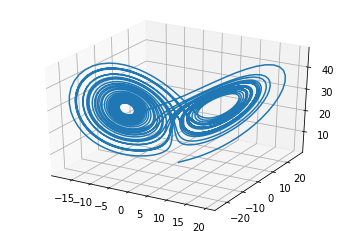

In [19]:
%matplotlib inline
script = """# Thanks https://en.wikipedia.org/wiki/Lorenz_system
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state,
t):
  x, y, z = state  # unpack the state vector
  return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(f, state0, t)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(states[:,0], states[:,1], states[:,2])
plt.show()"""
exec(script)

### Let's use this python script into a suite

In [22]:
import os, sys
lib = "/usr/local/lib/python3.6/site-packages/ecflow"; sys.path.append(lib)
import ecf
from ecf import (Client, Defs, Suite, Family, Task, Defstatus, Label, Edit)
home = os.getenv("HOME") + "/ecflow_server"
user = os.getenv("USER")
node = Suite("lorenz").add(  # SUITE DEFINITION
    Defstatus("suspended"),
    Edit(ECF_HOME=home, ECF_INCLUDE=home + "/include", ECF_FILES=home+"/files",
         ECF_OUT=home, 
# official submit on ecgate
#ECF_JOB_CMD="trimurti %USER% %SCHOST% %ECF_JOB% %ECF_JOBOUT%",
ECF_JOB_CMD="%ECF_JOB% > %ECF_JOBOUT% 2>&1",  # localhost run
# simple ssh submit:
# HOST="%ECF_NODE%", ECF_JOB_CMD="ssh %HOST% '%ECF_JOB% > %ECF_JOBOUT% 2>&1'",
         ECF_EXTN=".ecf", USER=user, SCHOST="localhost", ),
    Family("ecf").add(
        Edit(ECF_EXTN=".ecg"),
        Task("compute").add(), ))
with open(home + "/files/compute.ecg", 'w') as task_template:
    print("""#!%SHELL:/bin/bash%
%include <head.h>
python3 <<\@@@
""" + script + """
@@@
%include <tail.h>
""", file=task_template)
defs = Defs(); defs.add_suite(node)
path = '/' + node.name()
client = Client("localhost@%s" % os.getenv("ECF_PORT", 2500))  # PYTHON CLIENT
client.replace(path, defs)  # load/replace the top node (suite)
client.begin_suite(node.name())  # BEGIN suite: UNKNOWN -> QUEUED
client.resume(path)  # RESUME suite: SUSPENDED -> create job and submit

* Check the suite is present into the server, with **ecflow_ui**.
* Check panel Script, Edit (+preprocess +submit as alias)
<!-- ![sublime](img/sublime.png) -->
![lorenz](img/lorenz.png)

In [23]:
dot = node.draw_graph()  # soon DRAW static graph... provided dot Graphiz is available

This script can be altered to display different attactors, changing the starting point:
* we change the original script to allow the presence of the ecflow variable XYZ, with a default value, to start from 1,1,1
* we add a new family, and few tasks, to run in parallel. We use different values for the variable XYZ.

A [list comprehension](https://en.wikipedia.org/wiki/List_comprehension) keeps verbosity low.

In [24]:
with open(home + "/files/compute.ecg", 'w') as fip:
    fip.write("""#!/bin/bash
%include <head.h>
python <<@@
""" + script.replace("[1.0, 1.0, 1.0]",
                     "%XYZ:[1.0, 1.0, 1.0]%") + """
@@
%include <tail.h>
""")

In [25]:
client.suspend('/' + node.name())
node.add(       
    Family("multi").add(  # once imported, alter script, run multiple tasks
           [Family("%02d" % num).add(
              Edit(XYZ="[%d.0, %d.0, %d.0]" % (num, num, num)),
              Task("compute"))
            for num in range(0, 5)]))
client.replace("/lorenz/multi", defs)

You can then press resume to get the tasks running in parallel and display the plots.

![multi](img/lorenz-ens.png)

# More complex Suite

An operational suite is built from families, essentially:

* make: retrieve sources, compile
* main: real-time processing
* arch: prodicts generation, postprocess, archive, ploting

![img](img/course59.png)

## [ENIAC](https://maths.ucd.ie/~plynch/eniac)

This is a not so simple suite example from a project thanks to [Prof. Peter Lynch](https://maths.ucd.ie/~plynch/UCD_Home_Page.html)

### Environment setup
* Family *make* retrieves the code from the web.

### Forecast run
* Family main retrieves analyses and run the model with postprocessing.

![running](img/eniac.png)

In [26]:
import os; files = os.getenv("HOME") + "/eniac"
import ecf; from ecf import Repeat, Trigger
if not os.path.exists(files): os.makedirs(files)
node = Suite("eniac").add(  # SUITE DEFINITION
    Defstatus("suspended"),
    Edit(ECF_HOME=home, ECF_INCLUDE=home + "/include", ECF_FILES=files,
         ECF_EXTN=".ecg", 
         WDIR="/tmp",
         URL="https://maths.ucd.ie/~plynch/eniac/",
         SRC="",
         ECF_JOB_CMD="%ECF_JOB% > %ECF_JOBOUT% 2>&1",
         INC="%WDIR%", ),
    Family("make").add(
            Label("info", "get sources"),
            Task("get").add(
                Edit(# INC="%ECF_INCLUDE%",
                     SRC="eniac.m GetICs.m", )), ),
    Family("main").add(
        Trigger("make eq complete"),
        Repeat("YM", 194901, 194901, 1, "integer"),
        Family("an").add(
            Label("info", "get analysis"),
            Edit(SRC="Case1-%YM%0503.z00  Case2-%YM%3003.z00  Case3-%YM%3103.z00  Case4-1949021303.z00 Case1-%YM%0603.z00  Case2-%YM%3103.z00  Case3-1949020103.z00  Case4-1949021403.z00",),
            Task("get")),
        Family("fc").add(Trigger("an eq complete"),
                         Edit(MFILE="eniac"),
                         Task("octave")),
        Family("postproc").add(
            Trigger("fc eq complete"),
            Edit(MFILE="GetICs"),
            Task("get").add(
                 Edit(SRC="%YM%0503.asc %YM%0603.asc %YM%3003.asc %YM%3103.asc 1949020103.asc 1949021303.asc 1949021403.asc",),),
            Task("octave").add(Trigger("get eq complete")))))
defs = ecf.Defs(); defs.add_suite(node) # DEFINITION
path = '/' + node.name() # CLIENT:
client = Client("localhost@%s" % os.getenv("ECF_PORT", 2500))  # PYTHON CLIENT
client.replace(path, defs)  # load/replace the top node (suite)
client.begin_suite(node.name())  # BEGIN suite: UNKNOWN -> QUEUED
# client.resume(path) # RESUME suite: SUSPENDED -> create job and submit

0

In [27]:
with open(files + "/get.ecg", 'w') as template:
    print("""#!/bin/bash
%include <head.h> 
cd %WDIR:/tmp%
for file in %SRC%; do curl %URL%/$file > %INC%/$file; done
pwd; ls
%include <tail.h>""", file=template)
    
with open(files + "/octave.ecg", 'w') as template:
    print("""#!/bin/bash
%include <head.h> 
cd %WDIR:/tmp%
pwd && ls  
set +e # ignore errors: error:   /tmp/GetICs.m at line 199, column 1
octave <<\@@
# includenopp <%MFILE:eniac.m%>
 %MFILE:eniac%
@@
set -e
%include <tail.h>""", file=template)

In [28]:
%%bash
# which docker && docker pull eowyn/alpine-ecflow > /dev/null || echo "ERR: docker not found?\"\n",
remote="https://raw.githubusercontent.com/morianemo/alpine-ecflow/master/Dockerfile"
# [ ! -f Dockerfile ] && curl $remote > Dockerfile
# [ ! -f cmake-3.13.2.tar.gz ] && wget https://github.com/Kitware/CMake/releases/download/v3.13.2/cmake-3.13.2.tar.gz
#  build -t ecflow-alp . > /dev/null
# docker run -t --net=host ecflow ecflow_client-alp --ping

In [35]:
%%bash
# docker run -t --net=host ecflow-alp ecflow_client --port 2500 --ping
docker run -t --net=host alpine-ecflow ecflow_client --port 2500 --ping

ping server(localhost:2500) succeeded in 00:00:00.000695  ~0 milliseconds


# Questions?